In [162]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
#from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
#mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
mnist = fetch_openml(name='mnist_784',version=1)

X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0


# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))


X, Y = X.iloc[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)


# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### A. Create a 10x10 grid to visualize 10 examples of each digit.

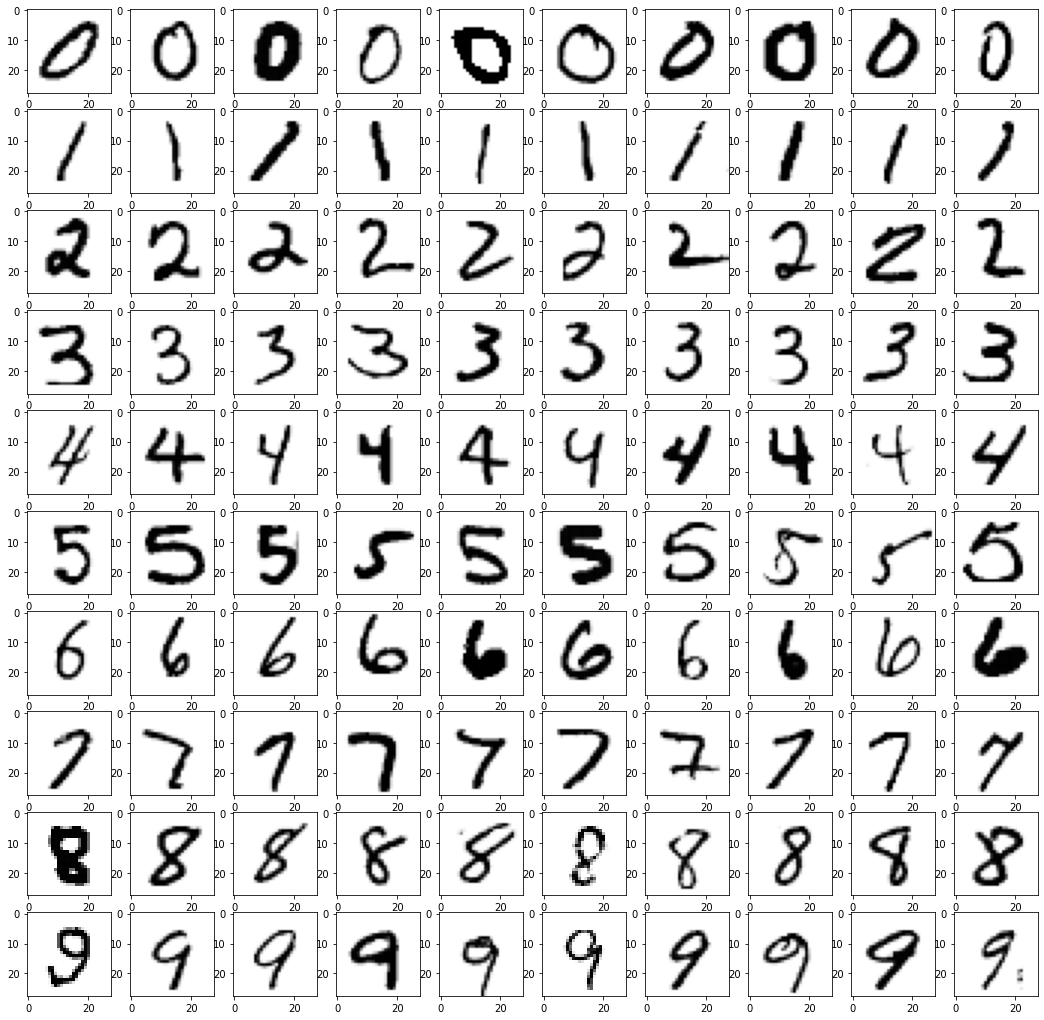

In [163]:
import pandas as pd
data = pd.DataFrame(mnist.data)
data['target'] = mnist.target

target_10s = {}
target_class = mnist.target.unique().to_list()
target_class.sort()

for target in target_class:
  target_data = pd.DataFrame(data[data.target == target])
  target_data.drop(columns=['target'], inplace=True)
  target_10s[target] = target_data.sample(n = 10).to_numpy()
i = 0
plt.figure(figsize=(20,20))
for target in target_class:
    i = i + 1;
    for j in range(len(target_10s[target])):
        ax = plt.subplot2grid((len(target_class)+1,len(target_10s[target])+1), (i,j))
        ax.imshow(np.reshape(target_10s[target][j], (28, 28)))
plt.show()

### B.  Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?
### Note, the answers may vary depending on what thresholds you set.

In [164]:
from sklearn.metrics import accuracy_score

In [128]:
from sklearn.naive_bayes import BernoulliNB

In [235]:
Bernouli_model = BernoulliNB(binarize=0.333)
Bernouli_model.fit(mini_train_data, mini_train_labels)
y_bi_pred = Bernouli_model.predict(dev_data)
print("Accuracy score: ", round(accuracy_score(dev_labels, y_bi_pred) * 100.0,2))

Accuracy score:  82.0


### Checking at different Thresholds

In [236]:
accuracy=[]
for i in [0.2,0.33,0.4,0.45,0.5]:
    Bernouli_model = BernoulliNB(binarize=i)
    Bernouli_model.fit(mini_train_data, mini_train_labels)
    y_pred = Bernouli_model.predict(dev_data)
    accuracy.append(round(accuracy_score(dev_labels, y_pred) * 100.0,2))
    

In [237]:
i = [0.2,0.33,0.4,0.45,0.5]

In [238]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, 'Accuracy')

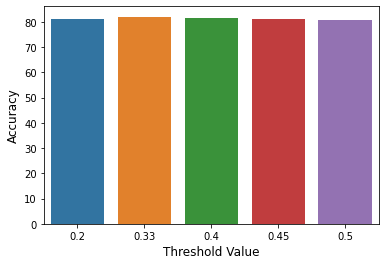

In [239]:
sns.barplot(x=i, y= accuracy)
plt.xlabel('Threshold Value', size= 12)
plt.ylabel('Accuracy', size= 12)


In [246]:
Bernouli_model = BernoulliNB(binarize=0.33)
Bernouli_model.fit(mini_train_data, mini_train_labels)


BernoulliNB(binarize=0.33)

In [247]:
pred1= Bernouli_model.predict(dev_data)

In [248]:
from sklearn.metrics import confusion_matrix 


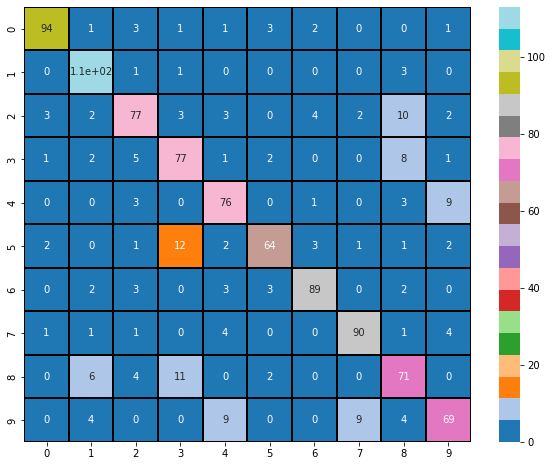

In [249]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(dev_labels,pred1), cmap= "tab20", annot=True, linewidths= 2, linecolor= 'black')
plt.show()

In [250]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [251]:
round(precision_score(dev_labels,pred, average='macro')*100,2)

82.0

In [252]:
round(recall_score(dev_labels,pred, average='macro')*100,2)

81.55

## MultinomialNB

In [255]:
from sklearn.naive_bayes import MultinomialNB

In [256]:
X_mapped_train =  pd.DataFrame(mini_train_data)
X_mapped_test =  pd.DataFrame(dev_data)

def scaled(val):
    if val >= 0.66:
      return 2.0
    elif val >= 0.33 and val<0.66:
      return 1.0
    elif val<0.33:
      return 0.0
    else:
      return val
    
value = np.vectorize(scaled)

for column in X_mapped_train.columns.to_list():
    column_data_train = X_mapped_train[column].to_numpy()
    column_data_test = X_mapped_test[column].to_numpy()
    result_train = value(column_data_train)
    result_test = value(column_data_test)
    X_mapped_train[column].update(pd.Series(result_train))
    X_mapped_test[column].update(pd.Series(result_test))

In [257]:
multinomialnb_model = MultinomialNB()

In [258]:
multinomialnb_model.fit(X_mapped_train, mini_train_labels)


MultinomialNB()

In [259]:
pred= multinomialnb_model.predict(X_mapped_test)

In [260]:
print(round(accuracy_score(dev_labels,pred) * 100.0,2))

79.3


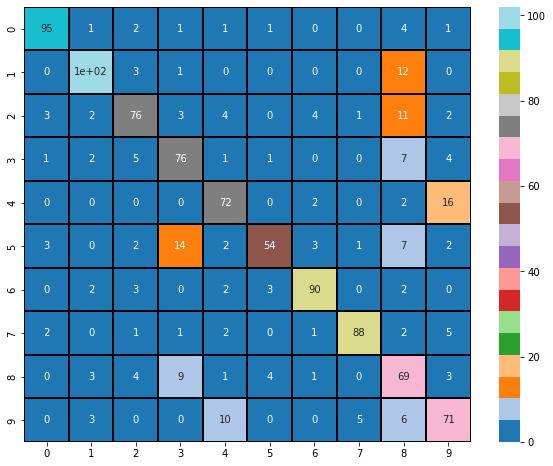

In [261]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(dev_labels,pred), cmap= "tab20", annot=True, linewidths= 2, linecolor= 'black')
plt.show()

In [262]:
round(precision_score(dev_labels,pred, average='macro')*100,2)

79.97

In [263]:
round(recall_score(dev_labels,pred, average='macro')*100,2)

78.84

## Results

### C. Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Could you explain why?

In [264]:
gaussiannb_model = GaussianNB()
# Fit the model with the mini training set
gaussiannb_model.fit(mini_train_data, mini_train_labels)
# Report accuracy for the dev set
print('Accuracy of Gaussian NB: {0:.3f}'.format(GaussianNB_model.score(dev_data,dev_labels)))
    

Accuracy of Gaussian NB: 0.589


In [265]:
pred= gaussiannb_model.predict(dev_data)

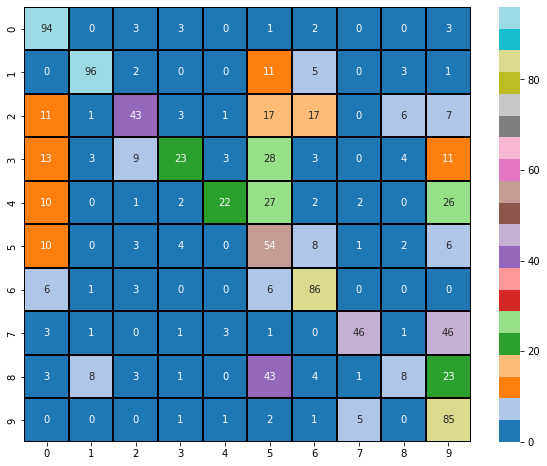

In [266]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(dev_labels,pred), cmap= "tab20", annot=True, linewidths= 2, linecolor= 'black')
plt.show()

In [267]:
round(precision_score(dev_labels,pred, average='macro')*100,2)

60.14

In [268]:
round(recall_score(dev_labels,pred, average='macro')*100,2)

54.7

## Results

In [313]:
import numpy as np

In [314]:
X.shape[0]

70000

In [315]:
val_random = X.iloc[np.random.choice(X.shape[0])]


Text(0.5, 1.0, 'Histogram of a Features')

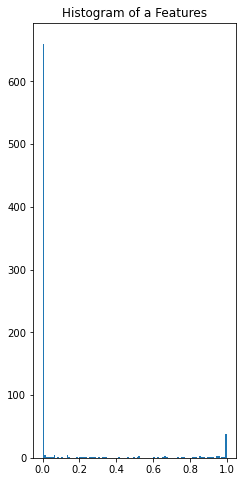

In [316]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
fig = plt.hist(val_random, 100)
plt.title('Histogram of a Features')

Text(0.5, 1.0, 'Histogram of a random image + Gaussian noise')

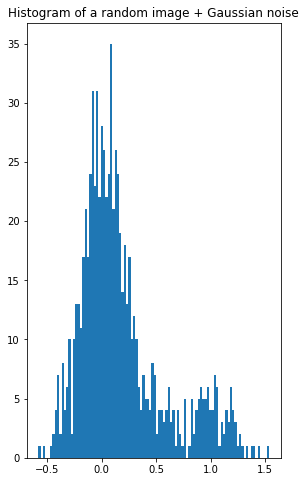

In [317]:
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 2)
fig = plt.hist(random_image + np.random.normal(0, 0.2, random_image.shape), 100)
plt.title('Histogram of a random image + Gaussian noise')

## Accuracy of Model after adding noise

In [318]:
new_train_data = mini_train_data + np.random.normal(0,0.2,mini_train_data.shape)
new_dev_data = dev_data + np.random.normal(0,0.2,mini_train_data.shape)
gaussiannb_model.fit(new_train_data, mini_train_labels)
print('Accuracy of new GaussianNB after adding noise = {0}'.format(gaussiannb_model.score(new_dev_data, dev_labels)*100))

Accuracy of new GaussianNB after adding noise = 81.0


In [319]:
pred= gaussiannb_model.predict(new_dev_data)

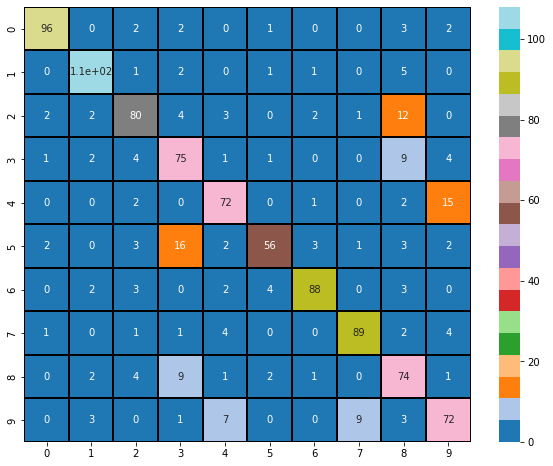

In [320]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(dev_labels,pred), cmap= "tab20", annot=True, linewidths= 2, linecolor= 'black')
plt.show()

In [321]:
round(precision_score(dev_labels,pred, average='macro')*100,2)

81.39

In [322]:
round(recall_score(dev_labels,pred, average='macro')*100,2)

80.48